In [252]:
import os
import numpy as np

from pydub import AudioSegment, effects
import librosa
import IPython.display as ipd
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pytz
import cv2

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

tz = pytz.timezone('Asia/Hong_Kong')

In [253]:
import copy
import random

In [48]:
def plotAudio(x, sr, title):
  plt.figure(figsize=(12,1))
  librosa.display.waveshow(x, sr)
  plt.title(title)

def playAudio(x, sr):
  ipd.display(ipd.Audio(data = x, rate=sr))

def visualizeMelSpec(mel_spectrogram, sr, title):
  librosa.display.specshow(mel_spectrogram, sr=sr, x_axis='time', y_axis='mel')
  plt.colorbar(format='%+2.0f dB')
  plt.title(title)

In [268]:
def add_noise(x, noise_factor):
  noise = np.random.normal(0, x.std(), x.size) * noise_factor
  return x + noise

def time_stretch(x, stretch_rate):
  return librosa.effects.time_stretch(x, stretch_rate)

def pitch_scale(x, sr, num_semitones):
  # Num of Semitones = positive or negative number, don't have to be integer
  # Positive number = scale go up
  # Negative number = scale do down
  # Ex. +1 semitones means go from C to D
  # Ex. -2 semitones means go from E to C
  
  return librosa.effects.pitch_shift(x, sr, num_semitones)

def random_gain(x, min_factor, max_factor):
  gain_factor = random.uniform(min_factor, max_factor)
  return x * gain_factor


# No need to do invert polarity as mel spectrogram will end up the same with or without it
def invert_polarity(x):
  return x * -1




In [41]:
def mel_spectrogram(processed_x, sr):
  splitDuration = 4
  dimension = (256, 256)
  
  # Split at or add padding to splitDuration (hyperparameter)
  #   if remaining duration is less than 1 sec, remove
  duration = len(processed_x) / sr
  size = sr * splitDuration

  if (duration < splitDuration):
    processed_x = np.pad(processed_x, (0, size - len(processed_x)), 'constant')
  elif (duration > splitDuration):
    processed_x = processed_x[0:size]
  
  # Extract Mel-Sectrogram
  mel_spec = librosa.feature.melspectrogram(y=processed_x, sr=sr)
  mel_spec = librosa.amplitude_to_db(mel_spec, ref=np.min)

  # Resize Mel-Spectrogram
  mel_spec = cv2.resize(mel_spec, dimension, interpolation=cv2.INTER_CUBIC)
  
  return mel_spec

In [264]:
def processOne(index):  
  labels_dict = {'neu': 'Neutral',
        'fru': 'Frustration',
        'ang': 'Anger',
        'sad': 'Sadness',
        'hap': 'Happiness',
        'exc': 'Excitement',
        'sur': 'Surprise',
        'dis': 'Disgust',
        'fea': 'Fear'}

  data = []
  labels = []
  sampling_rates = []

  count = 0

  # range 1 to 2 means loading Session 1 only
  # If want to load session 2, change to range 2 to 3
  # If want to load all sessions, change to 1 to 6
  for i in list(range(1, 6)):
    data_path = os.path.join(os.getcwd(), 'Data/IEMOCAP/Sentences/Session' + str(i))
    labels_dir = os.path.join(data_path, 'evaluation/')
    session = 'Session' + str(i)

    for dirname, _, filenames in os.walk(data_path):
      folderName = dirname.split("/")[-1]

      if (folderName != "evaluation" and folderName != "categorical"):
        for filename in filenames:

          if (filename == 'desktop.ini' or filename == 'desktop.in.txt' or filename == '.DS_Store' or filename == '.DS'):
            continue

          # Load Label
          recording_name = filename[:filename.rfind('_')]
          label_path = labels_dir + recording_name + '.txt'

          sentence_name = filename.split('.')[0]

          with open(label_path) as f:
            line = [line.strip() for line in f.readlines() if sentence_name in line]

          if (len(line) == 0):
            continue
          item = line[0].split('\t')
          if (len(item) < 3):
            continue
          
          ## NEW (Don't include here)
          if (count < index):
            count += 1
            continue
          ## NEW End

          label_code = line[0].split('\t')[2]
          if (label_code in labels_dict):
            label = labels_dict[label_code]
          else:
            label = 'Other'

          # Load Audio and x
          wav_path = os.path.join(dirname, filename)

          # _extractData()
          audio = AudioSegment.from_file(wav_path)
          sr = audio.frame_rate
          
          # Process Audio
          audio = effects.normalize(audio, headroom = 5.0) # TODO: Try other head room
          processed_x = np.array(audio.get_array_of_samples(), dtype = 'float32')          
          processed_x, _ = librosa.effects.trim(processed_x, top_db = 30) # Can change this top_db
          
          ### Noise reduction is SUPER SLOW
          # processed_x = nr.reduce_noise(processed_x, sr=sr)
          
          ### NEW (Data Augmentation)
          original_x = copy.deepcopy(processed_x)
          
          # processed_x = pitch_scale(processed_x, sr, -3) # -3 to 3
          # processed_x = time_stretch(processed_x, 1.2) # 0.8 - 1.2
          # processed_x = random_gain(processed_x, 0.8, 1.2) # 0.8 - 1.2
          # processed_x = add_noise(processed_x, 0.2) # 0 - 0.2
          
          new_x = processed_x
          ### NEW End
          
          original_mel = mel_spectrogram(original_x, sr)
          new_mel = mel_spectrogram(new_x, sr)
          
          return original_x, new_x, original_mel, new_mel, sr, label, wav_path

Label: Other
Original Audio:


New Audio



Wave Form:


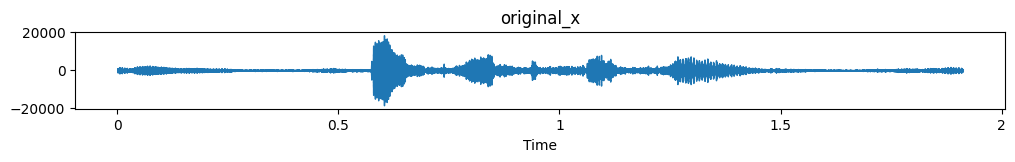

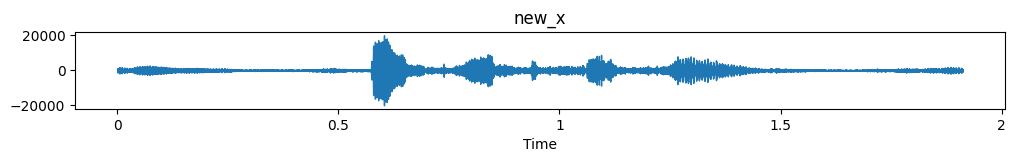

In [265]:
original_x, new_x, original_mel, new_mel, sr, label, wav_path = processOne(5)
print("Label: " + label)
print("Original Audio:")
playAudio(original_x, sr)
print("New Audio")
playAudio(new_x, sr)

print('\nWave Form:')
plotAudio(original_x, sr, "original_x")
plotAudio(new_x, sr, "new_x")

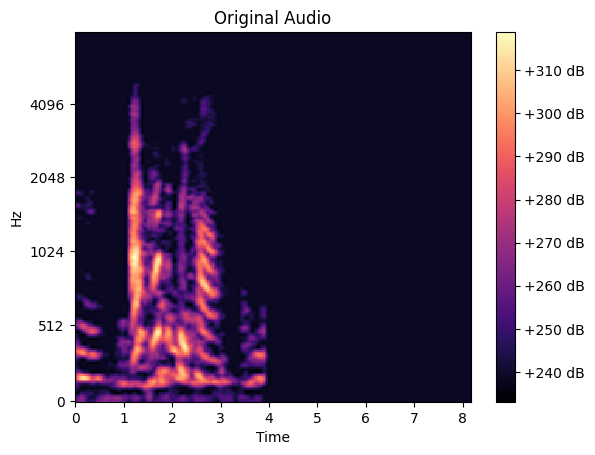

In [266]:
visualizeMelSpec(original_mel, sr, "Original Audio")

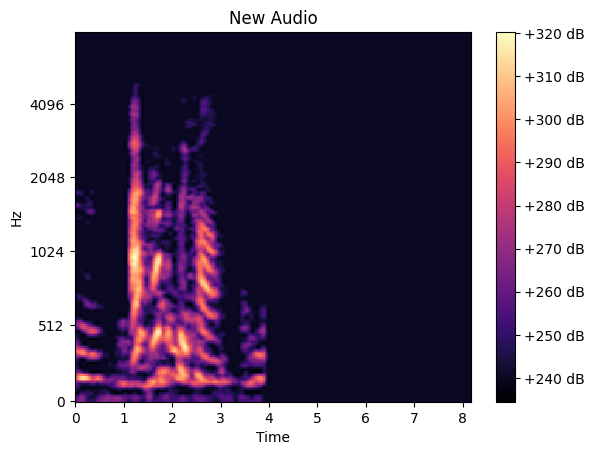

In [267]:
visualizeMelSpec(new_mel, sr, "New Audio")